In [7]:
# import plotly.express as px
# fig = px.scatter_3d(results, x='1 - eConfidence Score', y='Bregman Information', z='NLL')
# fig.show();

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from copy import deepcopy
from torch.nn.functional import softplus, binary_cross_entropy
from torchmetrics.classification import BinaryCalibrationError, BinaryAUROC

save_file = 'plots/x={}__y={}__hue={}__col={}__style={}.pdf'

In [9]:
from scipy.optimize import minimize
from scipy.special import expit
from sklearn.metrics import log_loss
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import polynomial_kernel
import time
from tqdm import tqdm

class TemperatureScaling():

    def __init__(self, temp=1, maxiter=100, solver="BFGS", loss='NLL'):
        """
        Initialize class
        Params:
            temp (float): starting temperature, default 1
            maxiter (int): maximum iterations done by optimizer, however 8 iterations have been maximum.
        """
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver
        self.loss = loss

    def _loss_fun(self, x, logits, true):
        scaled_l = self.predict(logits, x)
        loss = log_loss(true, expit(scaled_l))
        return loss

    # Find the temperature
    def fit(self, logits, true, verbose=False):
        true = true.flatten() # Flatten y_val
        opt = minimize(self._loss_fun, x0 = 1, args=(logits, true), options={'maxiter':self.maxiter}, method = self.solver)
        self.temp = opt.x[0]

        if verbose:
            print("Temperature:", 1/self.temp)

        return opt

    def predict(self, logits, temp = None):
        if not temp:
            return logits/self.temp
        else:
            return logits/temp

In [10]:
def AUROC(preds, targets):
    return BinaryAUROC()(preds, targets)

def ECE(preds, targets, bins=15):
    metric = BinaryCalibrationError(n_bins=bins, norm='l1')
    return metric(preds, targets)

def ACC(preds, targets):
    return ((preds > 0.5) == targets).to(dtype=torch.float).mean()

def BI_softplus(logits, axis=0):
    return softplus(logits).mean(axis) - softplus(logits.mean(axis))

def load_val_set(model_ids):
    predss = []
    logits = []

    for model_id in model_ids:
        raw_data = torch.load('Model Soup/{}/AA_val1.csv.pt'.format(model_id))
        preds = raw_data['predict1.HOLDOUT_VAL1'][0][:, 1]
        predss.append(preds)
        logits.append(preds.logit())

    # ys are the same
    return torch.stack(predss), torch.stack(logits), raw_data['predict1.HOLDOUT_VAL1'][1].to(dtype=torch.float)

def load_test_set(model_ids, test_ids=['predict.HOLDOUT']):
    predss = []
    logits = []
    for model_id in model_ids:
        predss_inner = []
        logits_inner = []
        ys = []
        for test_id in test_ids:
            raw_data = torch.load('Model Soup/{}/AA_test.csv.pt'.format(model_id))
            preds = raw_data[test_id][0][:, 1]
            predss_inner.append(preds)
            logits_inner.append(preds.logit())
            ys.append(raw_data[test_id][1])
        predss.append(torch.concat(predss_inner))
        logits.append(torch.concat(logits_inner))
        # ys are the same across ensemble members

    return torch.stack(predss), torch.stack(logits), torch.concat(ys).to(dtype=torch.float)

test_ids = [
    'predict.DERM7PT',
    'predict.ISIC2020_SIDNEY',
    'predict.MSK', 
    'predict.PH2',
    'predict.SAM',
    'predict.SKINL2'
]

In [11]:
def SKCE_vector(kernel, predictions, outcomes):

    def SKCE_vectorized_helper(i,j):
        matrix_kernel = k_g_Xi_g_Xj[i,j] * np.eye(len(predictions[i]))
        return ((diff_outcomes_preds[i] @ matrix_kernel) @ np.array(diff_outcomes_preds[j]).T)

    predictions = predictions.numpy().reshape(-1,1)
    outcomes = outcomes.numpy().reshape(-1,1)
    n = len(outcomes)

    # Compute the kernel matrix for the pair
    k_g_Xi_g_Xj = kernel(predictions, predictions)

    # Compute the difference between unit vectors outcomes and predictions
    diff_outcomes_preds = np.array(outcomes - predictions)

    indices_upper_triangular = np.triu_indices(n, k=1)

    vhelper = np.vectorize(SKCE_vectorized_helper)
    results = vhelper(indices_upper_triangular[0], indices_upper_triangular[1])
    skce = np.sum(results)


    # Divide the SKCE by n over 2
    prefactor = (n* (n-1)) // 2
    skce /= prefactor

    return skce

def compute_skce(kernel, predictions, outcomes):
    return SKCE_vector(kernel, predictions, outcomes).item()

In [12]:
eces = []
skces = []
accs = []
nlls = []
aurocs = []
set_type = []
ens_type = []
ens_size = []
used_TS = []
seeds = []

reps = 40
for seed in tqdm(range(reps), desc="Processing", total=reps):
    np.random.seed(seed)
    for size in range(1, 6):





        # homogeneous ens
        model_arch = np.random.choice(range(8), 1)
        model_rep = np.random.choice(range(5), size, replace=False)
        model_ids = ['0{}0.2{}'.format(m, n) for m in model_arch for n in model_rep]
        
        pss_val, _, ys_val = load_val_set(model_ids)
        pss_test_id, _, ys_test_id = load_test_set(model_ids)
        pss_test_ood, _, ys_test_ood = load_test_set(model_ids, test_ids=test_ids)
        
        eps_val = pss_val.mean(0)
        eps_test_id = pss_test_id.mean(0)
        eps_test_ood = pss_test_ood.mean(0)



        nlls.append(binary_cross_entropy(eps_test_id, ys_test_id).item())
        accs.append(ACC(eps_test_id, ys_test_id).item())
        eces.append(ECE(eps_test_id, ys_test_id).item())
        aurocs.append(AUROC(eps_test_id, ys_test_id).item())
        ens_type.append('Homogeneous')
        set_type.append('In-Domain')
        ens_size.append(size)
        used_TS.append('No')
        seeds.append(seed)
        
        nlls.append(binary_cross_entropy(eps_test_ood, ys_test_ood).item())
        accs.append(ACC(eps_test_ood, ys_test_ood).item())
        eces.append(ECE(eps_test_ood, ys_test_ood).item())
        aurocs.append(AUROC(eps_test_ood, ys_test_ood).item())
        ens_type.append('Homogeneous')
        set_type.append('Out-of-Domain')
        ens_size.append(size)
        used_TS.append('No')
        seeds.append(seed)
        
        TS = TemperatureScaling()
        TS.fit(eps_val.logit().numpy(), ys_val.numpy())
        TS_eps_test_id = torch.from_numpy(TS.predict(eps_test_id.logit().numpy())).sigmoid()
        TS_eps_test_ood = torch.from_numpy(TS.predict(eps_test_ood.logit().numpy())).sigmoid()
        
        nlls.append(binary_cross_entropy(TS_eps_test_id, ys_test_id).item())
        accs.append(ACC(TS_eps_test_id, ys_test_id).item())
        eces.append(ECE(TS_eps_test_id, ys_test_id).item())
        aurocs.append(AUROC(eps_test_id, ys_test_id).item())
        ens_type.append('Homogeneous')
        set_type.append('In-Domain')
        ens_size.append(size)
        used_TS.append('Yes')
        seeds.append(seed)
        
        nlls.append(binary_cross_entropy(TS_eps_test_ood, ys_test_ood).item())
        accs.append(ACC(TS_eps_test_ood, ys_test_ood).item())
        eces.append(ECE(TS_eps_test_ood, ys_test_ood).item())
        aurocs.append(AUROC(eps_test_ood, ys_test_ood).item())
        ens_type.append('Homogeneous')
        set_type.append('Out-of-Domain')
        ens_size.append(size)
        used_TS.append('Yes')
        seeds.append(seed)

        # heterogeneous ens
        model_arch = np.random.choice(range(8), size, replace=False)
        model_rep = np.random.choice(range(5), 1)
        model_ids = ['0{}0.2{}'.format(m, n) for m in model_arch for n in model_rep]
        
        pss_val, _, ys_val = load_val_set(model_ids)
        pss_test_id, _, ys_test_id = load_test_set(model_ids)
        pss_test_ood, _, ys_test_ood = load_test_set(model_ids, test_ids=test_ids)
        
        eps_val = pss_val.mean(0)
        eps_test_id = pss_test_id.mean(0)
        eps_test_ood = pss_test_ood.mean(0)

        nlls.append(binary_cross_entropy(eps_test_id, ys_test_id).item())
        accs.append(ACC(eps_test_id, ys_test_id).item())
        eces.append(ECE(eps_test_id, ys_test_id).item())
        aurocs.append(AUROC(eps_test_id, ys_test_id).item())
        set_type.append('In-Domain')
        ens_type.append('Heterogeneous')
        ens_size.append(size)
        used_TS.append('No')
        seeds.append(seed)
        
        nlls.append(binary_cross_entropy(eps_test_ood, ys_test_ood).item())
        accs.append(ACC(eps_test_ood, ys_test_ood).item())
        eces.append(ECE(eps_test_ood, ys_test_ood).item())
        aurocs.append(AUROC(eps_test_ood, ys_test_ood).item())
        set_type.append('Out-of-Domain')
        ens_type.append('Heterogeneous')
        ens_size.append(size)
        used_TS.append('No')
        seeds.append(seed)
        
        TS = TemperatureScaling()
        TS.fit(eps_val.logit().numpy(), ys_val.numpy())
        TS_eps_test_id = torch.from_numpy(TS.predict(eps_test_id.logit().numpy())).sigmoid()
        TS_eps_test_ood = torch.from_numpy(TS.predict(eps_test_ood.logit().numpy())).sigmoid()
        
        nlls.append(binary_cross_entropy(TS_eps_test_id, ys_test_id).item())
        accs.append(ACC(TS_eps_test_id, ys_test_id).item())
        eces.append(ECE(TS_eps_test_id, ys_test_id).item())
        aurocs.append(AUROC(eps_test_id, ys_test_id).item())
        set_type.append('In-Domain')
        ens_type.append('Heterogeneous')
        ens_size.append(size)
        used_TS.append('Yes')
        seeds.append(seed)
        
        nlls.append(binary_cross_entropy(TS_eps_test_ood, ys_test_ood).item())
        accs.append(ACC(TS_eps_test_ood, ys_test_ood).item())
        eces.append(ECE(TS_eps_test_ood, ys_test_ood).item())
        aurocs.append(AUROC(eps_test_ood, ys_test_ood).item())
        set_type.append('Out-of-Domain')
        ens_type.append('Heterogeneous')
        ens_size.append(size)
        used_TS.append('Yes')
        seeds.append(seed)

        args_list = [
        (polynomial_kernel, eps_test_id, ys_test_id),
        (polynomial_kernel, eps_test_ood, ys_test_ood),
        (polynomial_kernel, TS_eps_test_id, ys_test_id),
        (polynomial_kernel, TS_eps_test_ood, ys_test_ood)
        ]

         # Compute SKCE_vector in parallel using joblib
        skces_results = Parallel(n_jobs=-1)(delayed(compute_skce)(*args) for args in args_list)
        skces.extend(skces_results)

exp_results = pd.DataFrame({
    'Expected Calibration Error': eces,
    'Squared Kernel Calibration Error': skces,
    'Accuracy': accs,
    'Negative Log-Likelihood': nlls,
    'Area under ROC': aurocs,
    'Test Set': set_type,
    'Ensemble Type': ens_type,
    'Ensemble Size': ens_size,
    'Post-hoc Calibrated': used_TS,
    'Seed': seeds,
})

Processing: 100%|██████████| 40/40 [10:38:35<00:00, 957.90s/it]  


In [26]:
skces

[-1.6176981453440216e-05,
 0.07327631505200204,
 -0.00010024683870361679,
 0.06305607632474451,
 0.002035104419784069,
 0.016083912440578607,
 0.0024665218540995126,
 0.014708651809647819,
 0.0012561422983871102,
 0.01760702501440149,
 0.0014788872065742838,
 0.01701521242676825,
 0.003532111742899832,
 0.0033409345430346813,
 0.004038764780143411,
 0.00300224317815446,
 0.00266279296045345,
 0.006930611327562883,
 0.002697599571492123,
 0.006897941483348217,
 0.0005406451807400199,
 0.01951611798480358,
 0.001299687781989485,
 0.012385343399263253,
 -6.0012000709314776e-05,
 0.06043866885519006,
 -0.00016713894726540237,
 0.06459485447659266,
 0.0005365366300646374,
 0.02803467745426571,
 0.0007232581130165528,
 0.026462228250655296,
 0.0012505511469951428,
 0.013261893020216449,
 0.0011762892231109408,
 0.013498876676132655,
 0.0018398128740040615,
 0.011975573799742161,
 0.0017984540172662612,
 0.012080303672129714,
 0.000127595881355027,
 0.03657569569186845,
 -0.000161244901690979

In [25]:
len(eces)

1600

In [27]:
exp_results = pd.DataFrame({
    'Expected Calibration Error': eces,
    'Squared Kernel Calibration Error': skces+skces,
    'Accuracy': accs,
    'Negative Log-Likelihood': nlls,
    'Area under ROC': aurocs,
    'Test Set': set_type,
    'Ensemble Type': ens_type,
    'Ensemble Size': ens_size,
    'Post-hoc Calibrated': used_TS,
    'Seed': seeds,
})

In [28]:
exp_results

,Expected Calibration Error,Squared Kernel Calibration Error,Accuracy,Negative Log-Likelihood,Area under ROC,Test Set,Ensemble Type,Ensemble Size,Post-hoc Calibrated,Seed
0,0.032967,-0.000016,0.909253,0.218067,0.967023,In-Domain,Homogeneous,1,No,0
1,0.137720,0.073276,0.752554,0.601560,0.797813,Out-of-Domain,Homogeneous,1,No,0
2,0.035081,-0.000100,0.909253,0.213950,0.967023,In-Domain,Homogeneous,1,Yes,0
3,0.125685,0.063056,0.752554,0.561902,0.797813,Out-of-Domain,Homogeneous,1,Yes,0
4,0.036035,0.002035,0.918149,0.215145,0.969282,In-Domain,Heterogeneous,1,No,0
...,...,...,...,...,...,...,...,...,...,...
1595,0.128877,0.013732,0.750969,0.544261,0.804807,Out-of-Domain,Homogeneous,5,Yes,39
1596,0.051673,0.002995,0.927046,0.193597,0.976560,In-Domain,Heterogeneous,5,No,39
1597,0.074801,0.008918,0.784959,0.483271,0.824770,Out-of-Domain,Heterogeneous,5,No,39
1598,0.045748,0.003328,0.927046,0.192754,0.976560,In-Domain,Heterogeneous,5,Yes,39


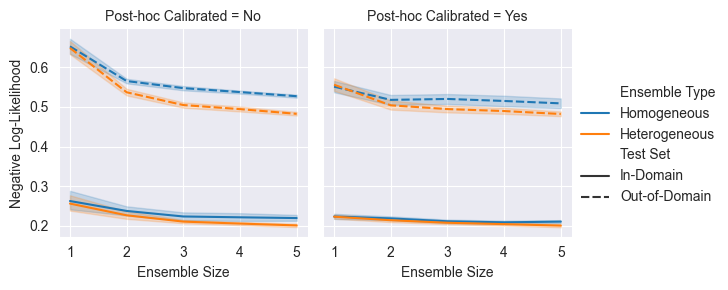

In [13]:
col = 'Post-hoc Calibrated'
x = 'Ensemble Size'
y = 'Negative Log-Likelihood'
hue = 'Ensemble Type'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

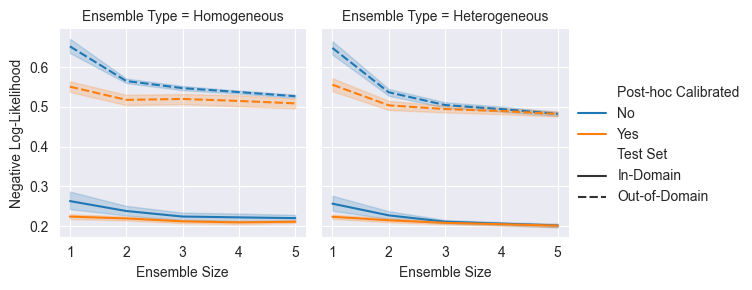

In [14]:
col = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Negative Log-Likelihood'
hue = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

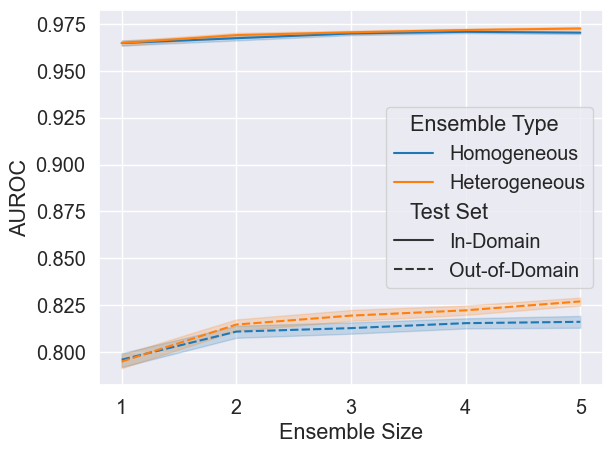

In [15]:
import matplotlib.pyplot as plt
hue = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Area under ROC'
col = 'Post-hoc Calibrated'
style = 'Test Set'

#with sns.plotting_context('paper', font_scale=.6):
with sns.plotting_context('notebook', font_scale=1.3):
#with sns.plotting_context(font_scale=1):
    g = sns.lineplot(data=exp_results[exp_results['Post-hoc Calibrated']=='No'], x=x, y=y, hue=hue, style=style)
    g.set_xticks(range(1, 6))
    g.set_ylabel('AUROC')
    plt.tight_layout()
    g.get_figure().savefig(save_file.format(x, y, hue, col, style));

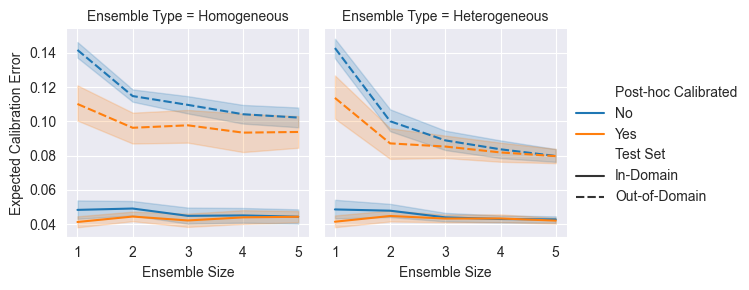

In [16]:
col = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Expected Calibration Error'
hue = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

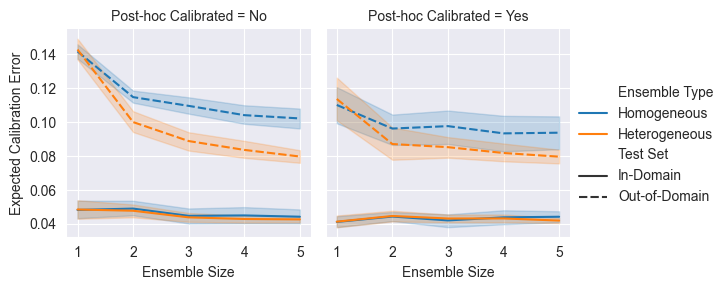

In [17]:
hue = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Expected Calibration Error'
col = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

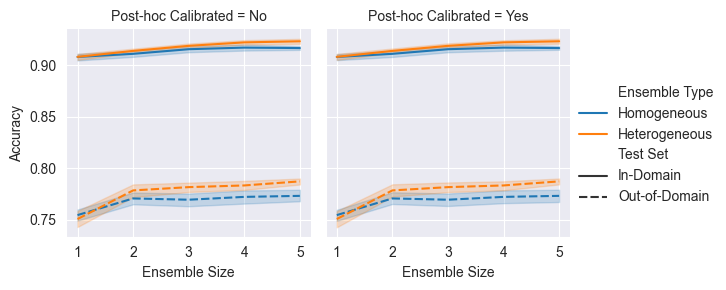

In [18]:
hue = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Accuracy'
col = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

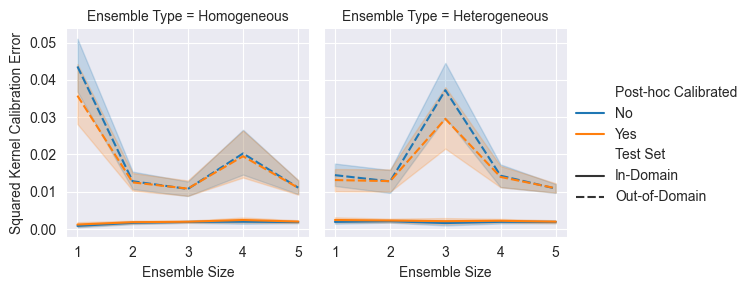

In [29]:
col = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Squared Kernel Calibration Error'
hue = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));


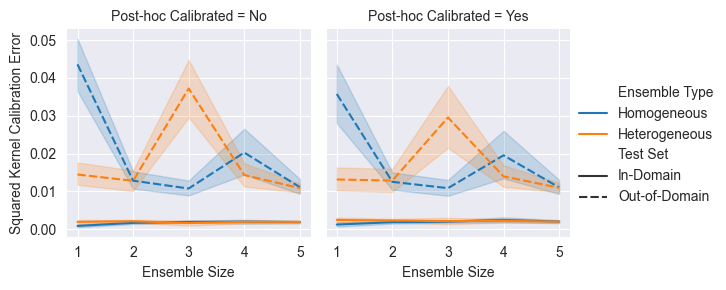

In [30]:
hue = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Squared Kernel Calibration Error'
col = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

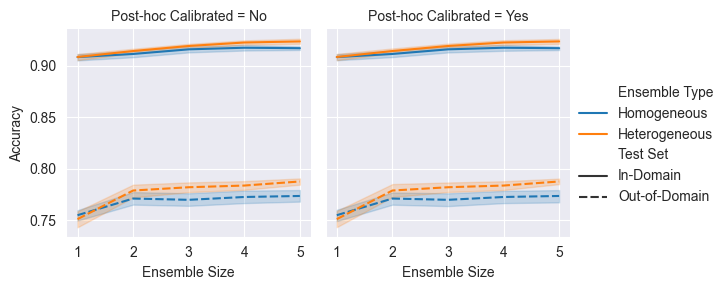

In [31]:
hue = 'Ensemble Type'
x = 'Ensemble Size'
y = 'Accuracy'
col = 'Post-hoc Calibrated'
style = 'Test Set'

g = sns.FacetGrid(exp_results, col=col)
g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, style=style)
g.add_legend()
g.savefig(save_file.format(x, y, hue, col, style));

In [19]:
# m=0 ResNet34
# m=1 ResNet50
model_ids = ['0{}0.2{}'.format(m, n) for m in range(2) for n in range(5)]

pss_val, zs_val, ys_val = load_val_set(model_ids)
pss_test_id, zs_test_id, ys_test_id = load_test_set(model_ids)
pss_test_ood, zs_test_ood, ys_test_ood = load_test_set(model_ids, test_ids=test_ids)

# avg ensemble preds
eps_val = pss_val.mean(0)
eps_test_id = pss_test_id.mean(0)
eps_test_ood = pss_test_ood.mean(0)

# avg ensemble preds in logit space
leps_val = pss_val.logit().mean(0).sigmoid()
leps_test_id = pss_test_id.logit().mean(0).sigmoid()
leps_test_ood = pss_test_ood.logit().mean(0).sigmoid()

In [20]:
BI_val = BI_softplus(zs_val)
BI_test_id = BI_softplus(zs_test_id)
BI_test_ood = BI_softplus(zs_test_ood)

eCS_val = torch.stack([eps_val, 1-eps_val]).min(0).values
eCS_test_id = torch.stack([eps_test_id, 1-eps_test_id]).min(0).values
eCS_test_ood = torch.stack([eps_test_ood, 1-eps_test_ood]).min(0).values

leCS_val = torch.stack([leps_val, 1-leps_val]).min(0).values
leCS_test_id = torch.stack([leps_test_id, 1-leps_test_id]).min(0).values
leCS_test_ood = torch.stack([leps_test_ood, 1-leps_test_ood]).min(0).values

NLL_val = binary_cross_entropy(ps_val, ys_val, reduction='none')
NLL_test_id = binary_cross_entropy(ps_test_id, ys_test_id, reduction='none')
NLL_test_ood = binary_cross_entropy(ps_test_ood, ys_test_ood, reduction='none')

ACC_val = ((ps_val > 0.5) == ys_val).to(dtype=torch.float)
ACC_test_id = ((ps_test_id > 0.5) == ys_test_id).to(dtype=torch.float)
ACC_test_ood = ((ps_test_ood > 0.5) == ys_test_ood).to(dtype=torch.float)

NameError: name 'ps_val' is not defined

In [ ]:
results = []

m = 1 # ResNet50
for i in range(5):
    ps_val = pss_val[m*5+i]
    ps_test_id = pss_test_id[m*5+i]
    ps_test_ood = pss_test_ood[m*5+i]

    CS_val = torch.stack([ps_val, 1-ps_val]).min(0).values
    CS_test_id = torch.stack([ps_test_id, 1-ps_test_id]).min(0).values
    CS_test_ood = torch.stack([ps_test_ood, 1-ps_test_ood]).min(0).values

    results.append(pd.DataFrame({
        '1 - Confidence Score': CS_val, 'Bregman Information': BI_val,
        '1 - eConfidence Score': eCS_val, 'NLL': NLL_val, 'ACC': ACC_val, 'Set': 'Val'
    }))
    results.append(pd.DataFrame({
        '1 - Confidence Score': CS_test_id, 'Bregman Information': BI_test_id,
        '1 - eConfidence Score': eCS_test_id, 'NLL': NLL_test_id, 'ACC': ACC_test_id, 'Set': 'Test ID'
    }))
    results.append(pd.DataFrame({
        '1 - Confidence Score': CS_test_ood, 'Bregman Information': BI_test_ood,
        '1 - eConfidence Score': eCS_test_ood, 'NLL': NLL_test_ood, 'ACC': ACC_test_ood, 'Set': 'Test OOD'
    }))
results = pd.concat(results).reset_index()
results['Log Bregman Information'] = np.log(results['Bregman Information'])
results['Log 1 - Confidence Score'] = np.log(results['1 - Confidence Score'])
results['Log 1 - eConfidence Score'] = np.log(results['1 - eConfidence Score'])
results.shape

In [ ]:
# !!!!!!!!!!!!! #
# Visually clearer with log scale
log_scale = True
# !!!!!!!!!!!!! #

In [ ]:
sns.histplot(data=results, x='Bregman Information', hue='Set', common_norm=False, stat="density", log_scale=log_scale, );

In [ ]:
sns.histplot(data=results, x='1 - Confidence Score', hue='Set', common_norm=False, stat="density", log_scale=log_scale, );

In [ ]:
sns.histplot(data=results, x='1 - eConfidence Score', hue='Set', common_norm=False, stat="density", log_scale=log_scale, );

In [ ]:
sns.kdeplot(data=results, x='Bregman Information', hue='Set', multiple="fill");

In [ ]:
sns.kdeplot(data=results, x='1 - Confidence Score', hue='Set', multiple="fill");

In [ ]:
sns.kdeplot(data=results, x='1 - eConfidence Score', hue='Set', multiple="fill");

In [ ]:
sns.histplot(data=results, x='Bregman Information', hue='Set', common_norm=False, stat="density", cumulative=True, fill=False, element="step", log_scale=log_scale);

In [ ]:
sns.histplot(data=results, x='1 - Confidence Score', hue='Set', common_norm=False, stat="density", cumulative=True, fill=False, element="step", log_scale=log_scale);

In [ ]:
sns.histplot(data=results, x='1 - eConfidence Score', hue='Set', common_norm=False, stat="density", cumulative=True, fill=False, element="step", log_scale=log_scale);

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.histplot, y='1 - Confidence Score', x='Bregman Information', common_norm=False)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='1 - Confidence Score', x='Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='Log 1 - Confidence Score', x='Log Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='1 - Confidence Score', x='1 - eConfidence Score', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='1 - eConfidence Score', x='Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='Log 1 - eConfidence Score', x='Log Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='NLL', x='1 - Confidence Score', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='NLL', x='Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.kdeplot, y='NLL', x='1 - eConfidence Score', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.histplot, y='ACC', x='Log Bregman Information', fill=True)
g.add_legend();

In [ ]:
g = sns.FacetGrid(results, col="Set")
g.map_dataframe(sns.histplot, y='ACC', x='1 - Confidence Score', fill=True)
g.add_legend();

In [ ]:
qs = np.arange(0.1, 1.1, 0.1)
BI_qs = [results.loc[results['Set']=='Val', 'Bregman Information'].quantile(q) for q in qs]
CS_qs = [results.loc[results['Set']=='Val', '1 - Confidence Score'].quantile(q) for q in qs]
eCS_qs = [results.loc[results['Set']=='Val', '1 - eConfidence Score'].quantile(q) for q in qs]

th_results = []
for i in range(len(qs)):
    th_results_ = deepcopy(results.loc[(results['Bregman Information']<=BI_qs[i]) & (results['Set']!='Val')])
    th_results_['q'] = qs[i]
    th_results_['Type'] = 'Bregman Information'
    th_results.append(th_results_)

    th_results_ = deepcopy(results.loc[(results['1 - Confidence Score']<=CS_qs[i]) & (results['Set']!='Val')])
    th_results_['q'] = qs[i]
    th_results_['Type'] = 'Confidence Score'
    th_results.append(th_results_)

    th_results_ = deepcopy(results.loc[(results['1 - eConfidence Score']<=eCS_qs[i]) & (results['Set']!='Val')])
    th_results_['q'] = qs[i]
    th_results_['Type'] = 'eConfidence Score'
    th_results.append(th_results_)

th_results = pd.concat(th_results).reset_index()

In [ ]:
sns.lineplot(data=th_results, x='q', y='NLL', hue='Type', style='Set');

In [ ]:
sns.lineplot(data=th_results, x='q', y='ACC', hue='Type', style='Set');

In [ ]:
# CS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(ps_val, ys_val), binary_cross_entropy(ps_test_id, ys_test_id), binary_cross_entropy(ps_test_ood, ys_test_ood))
print('ACC', ACC(ps_val, ys_val), ACC(ps_test_id, ys_test_id), ACC(ps_test_ood, ys_test_ood))
print('ECE', ECE(ps_val, ys_val), ECE(ps_test_id, ys_test_id), ECE(ps_test_ood, ys_test_ood))

In [ ]:
# eCS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(eps_val, ys_val), binary_cross_entropy(eps_test_id, ys_test_id), binary_cross_entropy(eps_test_ood, ys_test_ood))
print('ACC', ACC(eps_val, ys_val), ACC(eps_test_id, ys_test_id), ACC(eps_test_ood, ys_test_ood))
print('ECE', ECE(eps_val, ys_val), ECE(eps_test_id, ys_test_id), ECE(eps_test_ood, ys_test_ood))

In [ ]:
# leCS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(leps_val, ys_val), binary_cross_entropy(leps_test_id, ys_test_id), binary_cross_entropy(leps_test_ood, ys_test_ood))
print('ACC', ACC(leps_val, ys_val), ACC(leps_test_id, ys_test_id), ACC(leps_test_ood, ys_test_ood))
print('ECE', ECE(leps_val, ys_val), ECE(leps_test_id, ys_test_id), ECE(leps_test_ood, ys_test_ood))

In [ ]:
class BIPlattScaling():

    def __init__(self, temp=1, bias=0, maxiter=100, solver="Nelder-Mead", loss='NLL'):
        self.temp = temp
        self.bias = bias
        self.maxiter = maxiter
        self.solver = solver
        self.loss = loss

    def _loss_fun(self, params, logits, BIs, true):
        #llogits = np.sign(logits) * BIs
        scaled_l = self.predict(logits, BIs, params[0], 0)
        #scaled_l = self.predict(logits, BIs, params[0])
        loss = log_loss(true, expit(scaled_l))
        return loss

    # Find the temperature
    def fit(self, logits, BIs, true):
        true = true.flatten() # Flatten y_val
        #import pdb; pdb.set_trace()
        opt = minimize(
            self._loss_fun, x0 = [1, 0], args=(logits, BIs, true),
            options={'maxiter':self.maxiter, 'disp':True}, method = self.solver)
        self.temp = opt.x[0]
        self.bias = opt.x[1]

        return opt

    def predict(self, logits, BIs, temp = None, bias = None):
        llogits = -np.sign(logits) * BIs
        if temp is None:
            llogits = llogits / self.temp
        else:
            llogits = llogits / temp
        if bias is None:
            llogits = llogits + self.bias
        else:
            llogits = llogits + bias
        return llogits

In [ ]:
class BITScaling():

    def __init__(self, temp=1, maxiter=100, solver="BFGS", loss='NLL'):
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver
        self.loss = loss

    def _loss_fun(self, params, logits, BIs, true):
        scaled_l = self.predict(logits, BIs, params)
        loss = log_loss(true, expit(scaled_l))
        return loss

    # Find the temperature
    def fit(self, logits, BIs, true):
        true = true.flatten() # Flatten y_val
        #import pdb; pdb.set_trace()
        opt = minimize(
            self._loss_fun, x0 = 1, args=(logits, BIs, true),
            options={'maxiter':self.maxiter, 'disp':True}, method = self.solver)
        self.temp = opt.x[0]

        return opt

    def predict(self, logits, BIs, temp = None):
        llogits = -np.sign(logits) * BIs
        if temp is None:
            llogits = llogits / self.temp
        else:
            llogits = llogits / temp
        return llogits

In [ ]:
TS = TemperatureScaling()
TS.fit(ps_val.logit().numpy(), ys_val.numpy())
TS_ps_val = torch.from_numpy(TS.predict(ps_val.logit().numpy())).sigmoid()
TS_ps_test_id = torch.from_numpy(TS.predict(ps_test_id.logit().numpy())).sigmoid()
TS_ps_test_ood = torch.from_numpy(TS.predict(ps_test_ood.logit().numpy())).sigmoid()

In [ ]:
BITS = BITScaling()
BITS.fit(ps_val.logit().numpy(), BI_val.log().numpy(), ys_val.numpy())
BITS_ps_val = torch.from_numpy(BITS.predict(ps_val.logit().numpy(), BI_val.log().numpy())).sigmoid()
BITS_ps_test_id = torch.from_numpy(BITS.predict(ps_test_id.logit().numpy(), BI_test_id.log().numpy())).sigmoid()
BITS_ps_test_ood = torch.from_numpy(BITS.predict(ps_test_ood.logit().numpy(), BI_test_ood.log().numpy())).sigmoid()
BITS_ys_test_ood = ys_test_ood[BITS_ps_test_ood.isnan().logical_not()]
BITS_ps_test_ood = BITS_ps_test_ood[BITS_ps_test_ood.isnan().logical_not()]

In [ ]:
# CS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(ps_val, ys_val), binary_cross_entropy(ps_test_id, ys_test_id), binary_cross_entropy(ps_test_ood, ys_test_ood))
print('ECE', ECE(ps_val, ys_val), ECE(ps_test_id, ys_test_id), ECE(ps_test_ood, ys_test_ood))

In [ ]:
# TS CS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(TS_ps_val, ys_val), binary_cross_entropy(TS_ps_test_id, ys_test_id), binary_cross_entropy(TS_ps_test_ood, ys_test_ood))
print('ECE', ECE(TS_ps_val, ys_val), ECE(TS_ps_test_id, ys_test_id), ECE(TS_ps_test_ood, ys_test_ood))

In [ ]:
# BITS CS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(BITS_ps_val, ys_val), binary_cross_entropy(BITS_ps_test_id, ys_test_id), binary_cross_entropy(BITS_ps_test_ood, BITS_ys_test_ood))
print('ECE', ECE(BITS_ps_val, ys_val), ECE(BITS_ps_test_id, ys_test_id), ECE(BITS_ps_test_ood, BITS_ys_test_ood))

In [ ]:
# eCS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(eps_val, ys_val), binary_cross_entropy(eps_test_id, ys_test_id), binary_cross_entropy(eps_test_ood, ys_test_ood))
print('ECE', ECE(eps_val, ys_val), ECE(eps_test_id, ys_test_id), ECE(eps_test_ood, ys_test_ood))

In [ ]:
TS = TemperatureScaling()
TS.fit(eps_val.logit().numpy(), ys_val.numpy())
TS_eps_val = torch.from_numpy(TS.predict(eps_val.logit().numpy())).sigmoid()
TS_eps_test_id = torch.from_numpy(TS.predict(eps_test_id.logit().numpy())).sigmoid()
TS_eps_test_ood = torch.from_numpy(TS.predict(eps_test_ood.logit().numpy())).sigmoid()

In [ ]:
# TS eCS
print('---| Val          | Test ID      | Test OOD')
print('NLL', binary_cross_entropy(TS_eps_val, ys_val), binary_cross_entropy(TS_eps_test_id, ys_test_id), binary_cross_entropy(TS_eps_test_ood, ys_test_ood))
print('ECE', ECE(TS_eps_val, ys_val), ECE(TS_eps_test_id, ys_test_id), ECE(TS_eps_test_ood, ys_test_ood))

In [ ]:
BITS.temp

In [ ]:
BITS.bias